In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit

from sktree import RandomForestClassifier, RandomForestRegressor
from sktree.stats import (
    FeatureImportanceForestClassifier,
    FeatureImportanceForestRegressor,
    PermutationForestRegressor,
)

seed = 12345

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def linear_model_ancova(sigma_factor=2.0, seed=None):
    r"""Test MIGHT using MSE from linear model simulation.

    See https://arxiv.org/pdf/1904.07830.pdf Figure 1.

    Y = Beta * X_1 + Beta * I(X_6 = 2) + \epsilon
    """
    beta = 10.0
    sigma = 10.0 / sigma_factor
    n_samples = 2200
    n_estimators = 125
    test_size = 0.1
    n_repeats = 500
    metric = "mse"
    permute_per_tree = True
    sample_dataset_per_tree = True

    rng = np.random.default_rng(seed)

    # sample covariates
    X_15 = rng.uniform(0, 1, size=(n_samples, 5))
    X_610 = np.zeros((n_samples, 5))
    for idx in range(5):
        buff = np.argwhere(
            rng.multinomial(1, [1.0 / 3, 1.0 / 3, 1.0 / 3], size=n_samples)
        )[:, 1]

        X_610[:, idx] = buff

    X = np.concatenate((X_15, X_610), axis=1)
    assert X_15.shape == (n_samples, 5)
    assert X_610.shape == (n_samples, 5)
    assert X.shape == (n_samples, 10)

    # sample noise
    epsilon = rng.normal(size=n_samples, loc=0.0, scale=sigma)

    # compute final y of (n_samples,)
    y = beta * X[:, 0] + (beta * (X[:, 5] - 2)) + epsilon

    # initialize hypothesis tester
    est = FeatureImportanceForestRegressor(
        RandomForestRegressor(
            max_features=1.0, random_state=seed, n_estimators=n_estimators, n_jobs=-1
        ),
        test_size=test_size,
        random_state=seed,
        permute_per_tree=permute_per_tree,
        sample_dataset_per_tree=sample_dataset_per_tree,
    )
    pvalue_dict = {}

    # test for X_1
    stat, pvalue = est.test(X.copy(), y.copy(), [0], metric=metric, n_repeats=n_repeats)
    print("X1: ", pvalue)
    pvalue_dict["X1"] = pvalue
    # assert pvalue < 0.05, f"pvalue: {pvalue}"

    # test for X_6
    stat, pvalue = est.test(X.copy(), y.copy(), [5], metric=metric, n_repeats=n_repeats)
    print("X6: ", pvalue)
    pvalue_dict["X6"] = pvalue
    # assert pvalue < 0.05, f"pvalue: {pvalue}"

    # test for a few unimportant other X
    for name, covariate_index in zip(["X2", "X7"], [1, 6]):
        # test for X_2, X_7
        stat, pvalue = est.test(
            X.copy(),
            y.copy(),
            [covariate_index],
            metric=metric,
            n_repeats=n_repeats,
        )
        print("X2/7: ", pvalue)
        pvalue_dict[name] = pvalue
        # assert pvalue > 0.05, f"pvalue: {pvalue}"

    return pvalue_dict


def linear_model_mars():
    pass


def random_forest_model():
    pass

In [4]:
def correlated_logit_model(beta=5.0, seed=None):
    r"""Test MIGHT using MSE from linear model simulation.

    See https://arxiv.org/pdf/1904.07830.pdf Figure 1.

    P(Y = 1 | X) = expit(beta * \\sum_{j=2}^5 X_j)
    """
    n_samples = 600
    n_estimators = 125
    n_jobs = -1
    max_features = "sqrt"
    test_size = 1.0 / 6
    metric = "mse"
    n_repeats = 200
    permute_per_tree = True
    sample_dataset_per_tree = True

    n = 500  # Number of time steps
    ar_coefficient = 0.15

    rng = np.random.default_rng(seed)

    X = np.zeros((n_samples, n))
    for idx in range(n_samples):
        # sample covariates
        white_noise = rng.standard_normal(size=n)

        # Create an array to store the simulated AR(1) time series
        ar1_series = np.zeros(n)
        ar1_series[0] = white_noise[0]

        # Simulate the AR(1) process
        for t in range(1, n):
            ar1_series[t] = ar_coefficient * ar1_series[t - 1] + white_noise[t]

        X[idx, :] = ar1_series

    # now compute the output labels
    y_proba = expit(beta * X[:, 1:5].sum(axis=1))
    assert y_proba.shape == (n_samples,)
    y = rng.binomial(1, y_proba, size=n_samples)  # .reshape(-1, 1)

    pvalue_dict = {}

    # initialize hypothesis tester
    est = FeatureImportanceForestClassifier(
        RandomForestClassifier(
            max_features=1.0,
            random_state=seed,
            n_estimators=n_estimators,
            n_jobs=-1,
        ),
        random_state=seed,
        test_size=test_size,
        permute_per_tree=permute_per_tree,
        sample_dataset_per_tree=sample_dataset_per_tree,
    )

    # test for X_2 important
    stat, pvalue = est.test(
        X.copy(),
        y.copy(),
        covariate_index=[1],
        n_repeats=n_repeats,
        metric=metric,
    )
    pvalue_dict["X2"] = pvalue
    print("X2: ", pvalue)
    # assert pvalue < 0.05, f"pvalue: {pvalue}"

    # test for X_1 unimportant
    stat, pvalue = est.test(X.copy(), y.copy(), [0], n_repeats=n_repeats, metric=metric)
    pvalue_dict["X1"] = pvalue
    print("X1: ", pvalue)
    # assert pvalue > 0.05, f"pvalue: {pvalue}"

    # test for X_500 unimportant
    stat, pvalue = est.test(
        X.copy(),
        y.copy(),
        [n - 1],
        n_repeats=n_repeats,
        metric=metric,
    )
    pvalue_dict["X500"] = pvalue
    print("X500: ", pvalue)
    # assert pvalue > 0.05, f"pvalue: {pvalue}"
    return pvalue_dict

# Run Experiment on Linear ANCOVA Model

In [5]:
pvalue_dict = defaultdict(list)
rng = np.random.default_rng(seed)

j_space = np.linspace(0.005, 2.25, 9)

for sigma_factor in j_space:
    for idx in range(5):
        new_seed = rng.integers(0, np.iinfo(np.uint32).max, dtype=np.uint32)

        elements_dict = linear_model_ancova(sigma_factor, new_seed)
        for key, value in elements_dict.items():
            pvalue_dict[key].append(value)
        pvalue_dict["sigma_factor"].append(sigma_factor)

df = pd.DataFrame(pvalue_dict)

(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X1:  0.001996007984031936
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X6:  0.001996007984031936
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X2/7:  0.001996007984031936
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X2/7:  1.0
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X1:  0.001996007984031936
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X6:  0.001996007984031936
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X2/7:  1.0
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X2/7:  0.001996007984031936
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X1:  1.0
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X6:  1.0
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X2/7:  1.0
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X2/7:  1.0
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X1:  0.001996007984031936
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X6:  0.001996007984031936
(125, 2200, 1) (125, 2200, 1)
(125, 2200, 1)
X2/7:  1.0
(125, 2200, 1) (125, 2200, 1)
(125, 2200

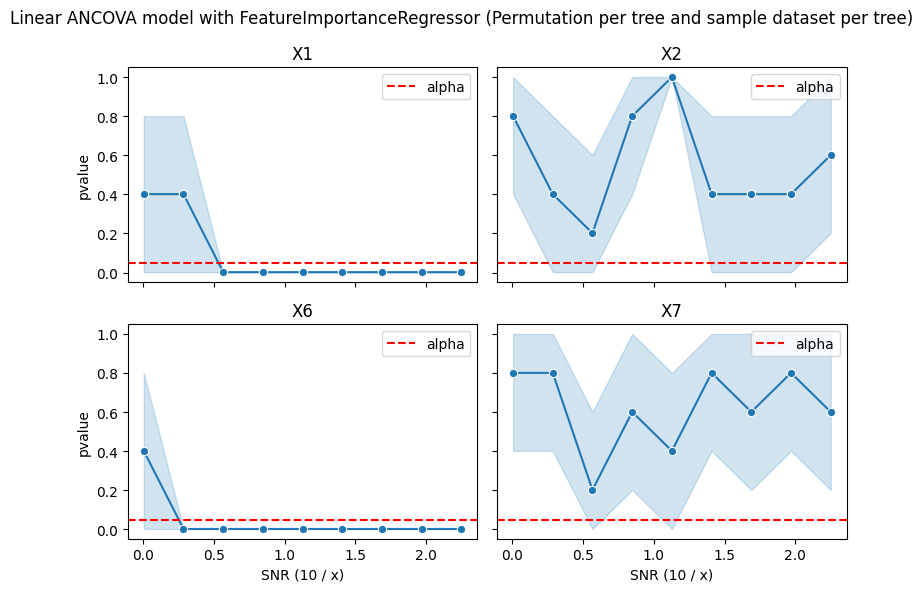

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X6", "X7"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (10 / x)")
    ax.legend()
fig.suptitle(
    "Linear ANCOVA model with FeatureImportanceRegressor (Permutation per tree and sample dataset per tree)"
)
fig.tight_layout()

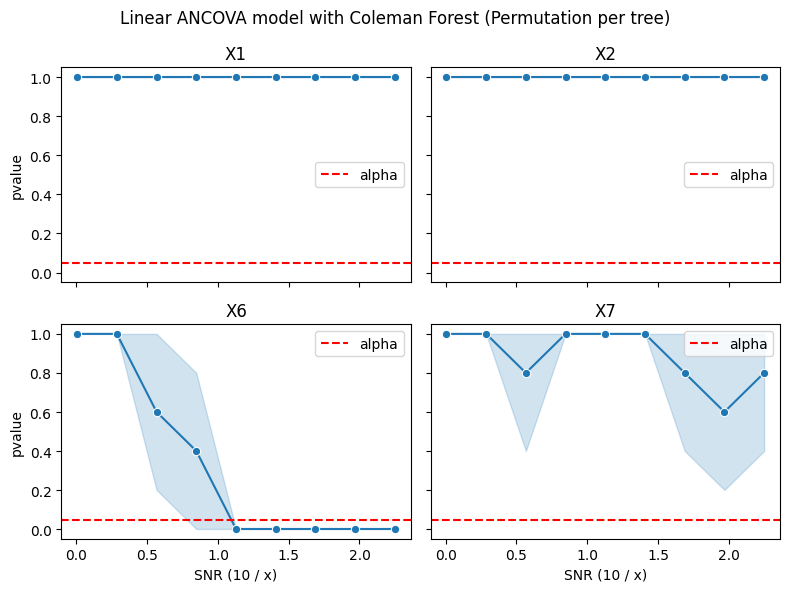

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X6", "X7"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (10 / x)")
    ax.legend()
fig.suptitle("Linear ANCOVA model with Coleman Forest (Permutation per tree)")
fig.tight_layout()

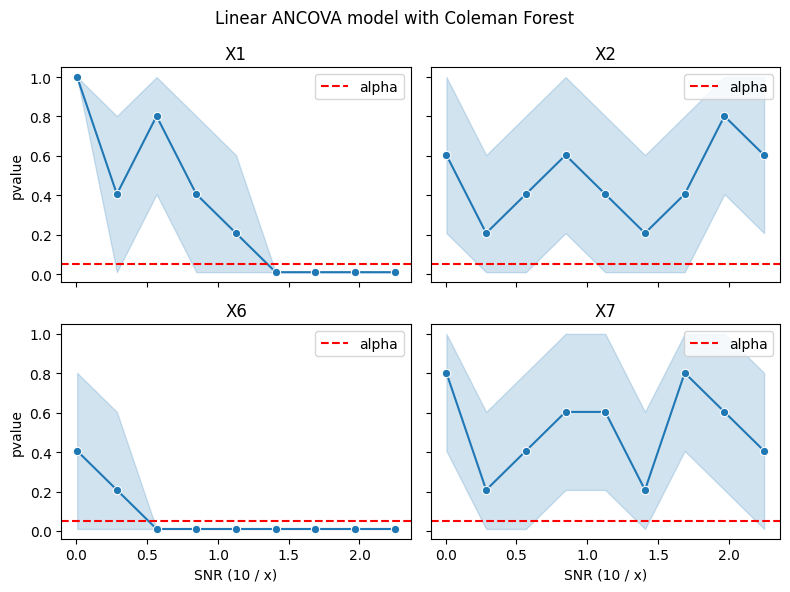

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X6", "X7"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (10 / x)")
    ax.legend()
fig.suptitle("Linear ANCOVA model with Coleman Forest")
fig.tight_layout()

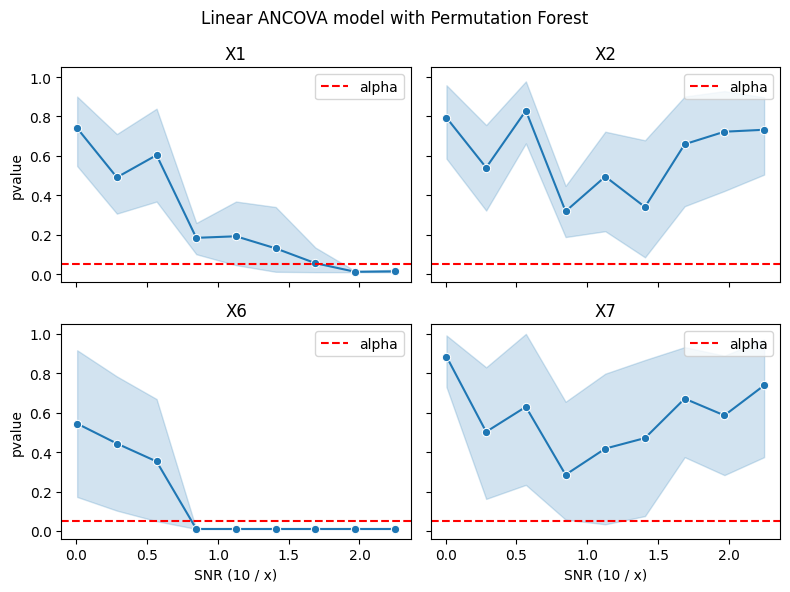

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X6", "X7"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (10 / x)")
    ax.legend()
fig.suptitle("Linear ANCOVA model with Permutation Forest")
fig.tight_layout()

# Run Experiment on Correlated Logit Model

In [7]:
j_space = np.linspace(0.005, 2.25, 9)
print(j_space)

[0.005    0.285625 0.56625  0.846875 1.1275   1.408125 1.68875  1.969375
 2.25    ]


In [ ]:
pvalue_dict = defaultdict(list)
rng = np.random.default_rng(seed)

beta_space = np.hstack((np.linspace(0.01, 2.5, 8), np.linspace(5, 20, 7)))
# beta_space = j_space.copy()
for beta in beta_space:
    for idx in range(5):
        new_seed = rng.integers(0, np.iinfo(np.uint32).max, dtype=np.uint32)

        elements_dict = correlated_logit_model(beta, new_seed)
        for key, value in elements_dict.items():
            pvalue_dict[key].append(value)
        pvalue_dict["sigma_factor"].append(beta)

df = pd.DataFrame(pvalue_dict)

(125, 600, 1) (125, 600, 1)
X2:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X1:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X500:  1.0
(125, 600, 1) (125, 600, 1)
X2:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X1:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X500:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X2:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X1:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X500:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X2:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X1:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X500:  1.0
(125, 600, 1) (125, 600, 1)
X2:  1.0
(125, 600, 1) (125, 600, 1)
X1:  1.0
(125, 600, 1) (125, 600, 1)
X500:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X2:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X1:  1.0
(125, 600, 1) (125, 600, 1)
X500:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X2:  0.004975124378109453
(125, 600, 1) (125, 600, 1)
X1:  0.004975124378

In [ ]:
print("done")

In [ ]:
display(df.head())

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X500"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (beta)")
    ax.legend()
fig.suptitle(
    "Correlated Logit model with FeatureImportanceForestClassifier (permute per tree and sample dataset)"
)
fig.tight_layout()

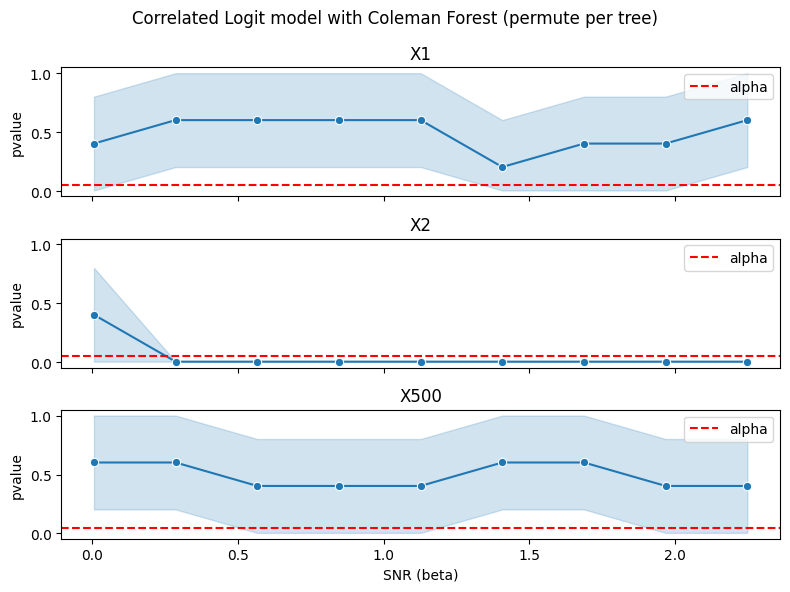

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X500"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (beta)")
    ax.legend()
fig.suptitle("Correlated Logit model with Coleman Forest (permute per tree)")
fig.tight_layout()